# Sudoku solver

In classic Sudoku, the objective is to fill a 9 × 9 grid with digits so that each column, each row, and each of the nine 3 × 3 subgrids that compose the grid (also called "boxes", "blocks", or "regions") contains all of the digits from 1 to 9.

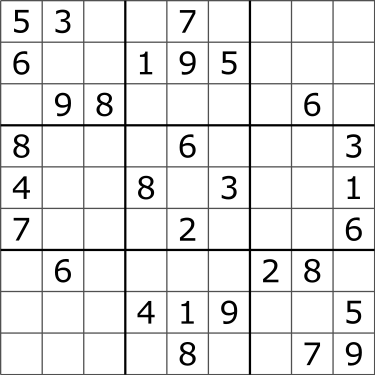

## Prepare environment

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from sudoku_solver.config.config import AppConfig
from sudoku_solver.data.dataset import prepare_dataset
from sudoku_solver.data.preprocess import (
    inverse_preprocess_input,
    inverse_preprocess_target,
)
from sudoku_solver.model.model import prepare_model
from sudoku_solver.model.training import train_model, search_hyperparameters
from sudoku_solver.model.evaluation import (
    plot_histories,
    evaluate_on_difficulties,
    evaluate_replacing_fixed_positions,
    evaluate_puzzle
)

import numpy as np
import tensorflow as tf
import keras

# Uncomment for debugging
# tf.config.run_functions_eagerly(True)

# Enable mixed precision training to speed up computation
# WARNING: turn off if you run this on CPU - it will significantly slow down training
# https://keras.io/api/mixed_precision/
#
# Enable when training takes too long - it lowered training time by 14% and increased error rate by 16%
keras.mixed_precision.set_global_policy("mixed_float16")

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

import mlflow

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
# tf.config.experimental.enable_op_determinism()

MODEL_FILE_NAME = "sudoku_solver.keras"

E0000 00:00:1747295260.060472    9707 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747295260.066619    9707 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment(experiment_name="Default")
mlflow.start_run()

<ActiveRun: >

### Hyperparameters

In [3]:
app_config = AppConfig.from_toml("sudoku_solver/config/base_config.toml")
app_config

AppConfig(DATA_SIZE_LIMIT=300000, BATCH_SIZE=256, LEARNING_RATE=0.001, EPOCHS=3, USE_RESIDUAL=True, USE_PRE_TRAINING=False, USE_DISK_CACHE=False, USE_CURRICULUM_LEARNING=False, CONSTRAINT_WEIGHT_START=0.1, CONSTRAINT_WEIGHT_END=0.6, FIXED_CELL_WEIGHT_START=10, FIXED_CELL_WEIGHT_END=5, USE_WEIGHT_SCHEDULING=False, USE_FIXED_NUMBER_LAYER=False, USE_DATASET_MIXING=False, PRIMARY_DATASET_SPLIT=0.9)

## Prepare dataset

In [4]:
train_datasets, val_dataset, test_dataset = prepare_dataset(
    app_config.BATCH_SIZE,
    size_limit=app_config.DATA_SIZE_LIMIT,
    use_disk_cache=app_config.USE_DISK_CACHE,
)

Trying to prepare dataset from disk


I0000 00:00:1747295267.649628    9707 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


Dataset ready.


Measuring pipeline performance...:  11%|█         | 111/1000 [00:01<00:13, 65.31it/s]

Average batch fetch time is: 0.024105628331502277


In [5]:
print("Validate dataset pipeline:\n")
for X_batch, y_batch in train_datasets[0].take(1):
    for X, y in zip(X_batch, y_batch):
        print(inverse_preprocess_input(X))
        print(inverse_preprocess_target(y))
        break

Validate dataset pipeline:

tf.Tensor(
[[1. 4. 9. 7. 2. 5. 3. 8. 6.]
 [0. 0. 5. 3. 9. 8. 1. 4. 7.]
 [7. 3. 8. 4. 1. 6. 9. 5. 2.]
 [8. 7. 3. 9. 6. 2. 4. 0. 5.]
 [0. 6. 4. 1. 5. 3. 7. 9. 8.]
 [5. 9. 0. 0. 4. 7. 6. 2. 3.]
 [3. 1. 7. 0. 8. 9. 2. 6. 4.]
 [4. 0. 2. 6. 3. 1. 5. 7. 9.]
 [9. 0. 0. 2. 0. 4. 8. 3. 1.]], shape=(9, 9), dtype=float64)
tf.Tensor(
[[ 1  4  9  7  2  5  3  8  6]
 [16 12  5  3  9  8  1  4  7]
 [ 7  3  8  4  1  6  9  5  2]
 [ 8  7  3  9  6  2  4 11  5]
 [12  6  4  1  5  3  7  9  8]
 [ 5  9 11 18  4  7  6  2  3]
 [ 3  1  7 15  8  9  2  6  4]
 [ 4 18  2  6  3  1  5  7  9]
 [ 9 15 16  2 17  4  8  3  1]], shape=(9, 9), dtype=int32)


In [6]:
train_batch_size = sum(1 for _ in train_datasets[0])
train_batch_size

111

## Search HyperParameter Space

In [7]:
tuner = search_hyperparameters(train_datasets, val_dataset, app_config)

best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)

Reloading Tuner from my_dir/my_project/tuner0.json
Search space summary
Default search space size: 3
constraint_weight (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 2.0, 'step': None, 'sampling': 'log'}
fixed_cell (Float)
{'default': 1.0, 'conditions': [], 'min_value': 1.0, 'max_value': 20.0, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
{'constraint_weight': 1.3473361541720905, 'fixed_cell': 9.776287913455848, 'learning_rate': 0.0003635889277344135}


## Train model

### Prepare model

In [8]:
model = prepare_model(app_config, best_hp)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9, 9, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 9, 9, 1)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 9, 9, 64)  │        640 │ cast[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 9, 9, 64)  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 9, 9, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 9, 9, 64)  │          0 │ add_1[0][0]     

 Total params: 7,944,713 (30.31 MB)

 Trainable params: 7,943,049 (30.30 MB)

 Non-trainable params: 1,664 (6.50 KB)

### Train

In [9]:
histories = train_model(model, train_datasets, val_dataset, app_config)

Epoch 1/3


I0000 00:00:1747295285.380821    9799 service.cc:148] XLA service 0x7fb47c0037a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747295285.380871    9799 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
W0000 00:00:1747295285.518493    9799 assert_op.cc:38] Ignoring Assert operator compile_loss/sudoku_loss/assert_equal_1/Assert/AssertGuard/Assert
I0000 00:00:1747295286.774684    9799 cuda_dnn.cc:529] Loaded cuDNN version 90700
I0000 00:00:1747295303.914957    9799 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.1231 - box_penalty: 0.0611 - col_penalty: 0.0598 - loss: 5.4987 - row_penalty: 0.0582

W0000 00:00:1747295333.826682    9799 assert_op.cc:38] Ignoring Assert operator compile_loss/sudoku_loss/assert_equal_1/Assert/AssertGuard/Assert



Penalties:
crossentropy_tracker:  1.244197
total_penalty_tracker:  0.09644286
row_penalty_tracker:  0.023475569
col_penalty_tracker:  0.024104636
box_penalty_tracker:  0.02400023
cell_penalty_tracker:  4.05437
222/222 ━━━━━━━━━━━━━━━━━━━━ 64s 152ms/step - accuracy: 0.1232 - box_penalty: 0.0610 - col_penalty: 0.0597 - loss: 5.4968 - row_penalty: 0.0580 - val_accuracy: 0.1135 - val_box_penalty: 0.0045 - val_col_penalty: 0.0063 - val_loss: 8.8761 - val_row_penalty: 0.0046 - learning_rate: 3.6359e-04
Epoch 2/3
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.2042 - box_penalty: 0.0130 - col_penalty: 0.0136 - loss: 4.4785 - row_penalty: 0.0135
Penalties:
crossentropy_tracker:  1.2039129
total_penalty_tracker:  0.081287704
row_penalty_tracker:  0.01997202
col_penalty_tracker:  0.020339778
box_penalty_tracker:  0.020020312
cell_penalty_tracker:  3.7800972
222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 138ms/step - accuracy: 0.2043 - box_penalty: 0.0130 - col_penalty: 0.0136 - loss: 4.4777 - row_pe

### Save model

In [10]:
model.save(MODEL_FILE_NAME)

## Evaluate model

### Plot training history as learning curves

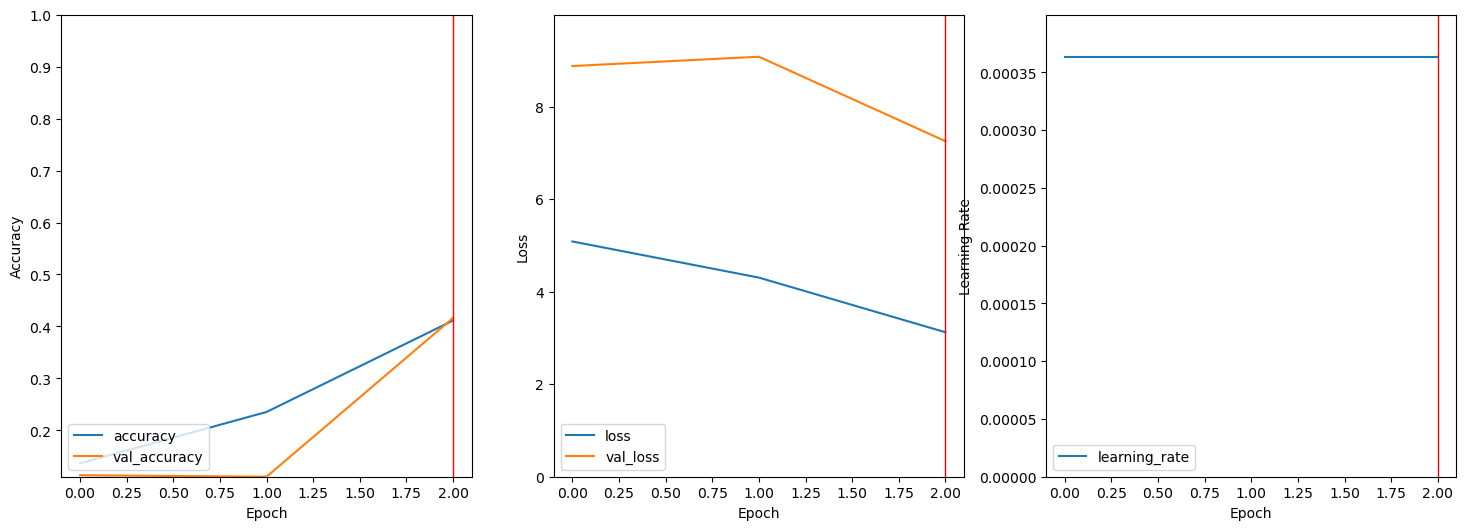

In [11]:
plot_histories(histories)

### Load model from disk to get reproducible results

In [12]:
model = keras.saving.load_model(MODEL_FILE_NAME)

### Evaluate selected puzzles

In [13]:
evaluate_puzzle(model,
    (
        "800250704"
        "420000000"
        "000008065"
        "000045300"
        "004603100"
        "007910000"
        "540700000"
        "000000089"
        "209086001"
    ),
    (
        "863259714"
        "425167938"
        "791438265"
        "612845397"
        "984673152"
        "357912846"
        "548791623"
        "176324589"
        "239586471"
    ),
)


Puzzle:
8 0 0 2 5 0 7 0 4
4 2 0 0 0 0 0 0 0
0 0 0 0 0 8 0 6 5
0 0 0 0 4 5 3 0 0
0 0 4 6 0 3 1 0 0
0 0 7 9 1 0 0 0 0
5 4 0 7 0 0 0 0 0
0 0 0 0 0 0 0 8 9
2 0 9 0 8 6 0 0 1

Actual solution:
8 6 3 2 5 9 7 1 4
4 2 5 1 6 7 9 3 8
7 9 1 4 3 8 2 6 5
6 1 2 8 4 5 3 9 7
9 8 4 6 7 3 1 5 2
3 5 7 9 1 2 8 4 6
5 4 8 7 9 1 6 2 3
1 7 6 3 2 4 5 8 9
2 3 9 5 8 6 4 7 1

Predicted solution:
8 6 1 2 5 8 7 1 2
3 2 5 4 6 7 1 2 8
1 7 1 1 1 8 8 6 4
9 9 2 7 3 4 3 5 7
8 8 4 6 7 2 2 8 7
2 1 7 9 2 7 5 4 5
5 3 1 7 9 9 8 1 1
6 8 2 4 2 3 5 8 9
1 7 9 4 8 6 1 1 2


W0000 00:00:1747295412.330090    9799 assert_op.cc:38] Ignoring Assert operator compile_loss/sudoku_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1747295412.333478    9799 assert_op.cc:38] Ignoring Assert operator compile_loss/sudoku_loss/assert_equal_1/Assert/AssertGuard/Assert



Accuracy on puzzle with 30 non-zero numbers is 0.4197530746459961


In [14]:
evaluate_puzzle(model,
    (
        "400510607"
        "050007020"
        "300020041"
        "035960000"
        "600400015"
        "014002008"
        "060075093"
        "001000700"
        "703098052"
    ),
    (
        "482519637"
        "156347829"
        "379826541"
        "835961274"
        "627483915"
        "914752368"
        "268175493"
        "591234786"
        "743698152"
    ),
)


Puzzle:
4 0 0 5 1 0 6 0 7
0 5 0 0 0 7 0 2 0
3 0 0 0 2 0 0 4 1
0 3 5 9 6 0 0 0 0
6 0 0 4 0 0 0 1 5
0 1 4 0 0 2 0 0 8
0 6 0 0 7 5 0 9 3
0 0 1 0 0 0 7 0 0
7 0 3 0 9 8 0 5 2

Actual solution:
4 8 2 5 1 9 6 3 7
1 5 6 3 4 7 8 2 9
3 7 9 8 2 6 5 4 1
8 3 5 9 6 1 2 7 4
6 2 7 4 8 3 9 1 5
9 1 4 7 5 2 3 6 8
2 6 8 1 7 5 4 9 3
5 9 1 2 3 4 7 8 6
7 4 3 6 9 8 1 5 2

Predicted solution:
3 1 1 4 8 9 5 8 7
1 4 5 2 3 7 2 2 2
3 7 6 8 2 5 8 4 1
8 3 5 9 5 1 1 7 8
5 8 8 3 8 3 3 2 4
7 1 4 7 5 2 9 8 8
1 5 1 1 7 4 2 9 2
2 2 9 6 2 1 7 5 5
7 8 2 7 9 8 1 4 1

Accuracy on puzzle with 37 non-zero numbers is 0.40740740299224854


### Evaluate on different difficulties

In [15]:
evaluate_on_difficulties(model, train_datasets)

W0000 00:00:1747295414.953811    9802 assert_op.cc:38] Ignoring Assert operator compile_loss/sudoku_loss/assert_equal_1/Assert/AssertGuard/Assert


Difficulty 1: loss=7.125183773040772, accuracy=0.46408179104328157
Average non-zero numbers in puzzle in one batch: 68

Difficulty 2: loss=6.8167273044586185, accuracy=0.4697386175394058
Average non-zero numbers in puzzle in one batch: 47

Difficulty 3: loss=6.961335802078247, accuracy=0.4523099988698959
Average non-zero numbers in puzzle in one batch: 44

Difficulty 4: loss=7.1298956871032715, accuracy=0.43176600635051726
Average non-zero numbers in puzzle in one batch: 41

Difficulty 5: loss=7.176063966751099, accuracy=0.4276330918073654
Average non-zero numbers in puzzle in one batch: 40

Difficulty 6: loss=7.285567855834961, accuracy=0.411048424243927
Average non-zero numbers in puzzle in one batch: 38

Difficulty 7: loss=7.346402597427368, accuracy=0.4048562914133072
Average non-zero numbers in puzzle in one batch: 37

Difficulty 8: loss=7.458587408065796, accuracy=0.3915364593267441
Average non-zero numbers in puzzle in one batch: 35

Difficulty 9: loss=7.506542110443116, accurac

{'Difficulty 1': 0.46408179104328157,
 'Difficulty 2': 0.4697386175394058,
 'Difficulty 3': 0.4523099988698959,
 'Difficulty 4': 0.43176600635051726,
 'Difficulty 5': 0.4276330918073654,
 'Difficulty 6': 0.411048424243927,
 'Difficulty 7': 0.4048562914133072,
 'Difficulty 8': 0.3915364593267441,
 'Difficulty 9': 0.38426409363746644,
 'Difficulty 10': 0.4036169022321701}

### Evaluate test set performance

In [16]:
loss, accuracy, *rest = model.evaluate(test_dataset)

W0000 00:00:1747295438.525354    9801 assert_op.cc:38] Ignoring Assert operator compile_loss/sudoku_loss/assert_equal_1/Assert/AssertGuard/Assert


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.4181 - box_penalty: 0.1127 - col_penalty: 0.1134 - loss: 7.2399 - row_penalty: 0.1132


In [17]:
print(f"On test set, model achieved accuracy: {accuracy} and loss: {loss}")

On test set, model achieved accuracy: 0.41777586936950684 and loss: 7.240980625152588


### Evaluate after replacing fixed positions with fixed numbers

In [18]:
evaluate_replacing_fixed_positions(model, test_dataset)

Test Set Accuracy after copying Fixed Numbers: 0.59889847


0.5988985

In [19]:
mlflow.end_run()

🏃 View run exultant-duck-752 at: http://127.0.0.1:8080/#/experiments/0/runs/74bbcdfbc9d6460fbc05f96f733edc77
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/0


The End